In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import sys
from dask import dataframe
sys.path.insert(0, "C:/workspace/stress_test_sim//libs")

from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator,\
                        Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher
from uniswap_v2_extractor import get_pool_v2_reserves_history, get_pool_v2_history, list_to_transaction_dictionary,\
                                    list_to_reserves_dictionary, pool_reserves_to_df, pool_history_to_df
from uniswap_v2_tools import show_swaps_count_moving_averages, show_swaps_reserves_evolution_through_time,\
                                show_pool_price_evolution_from_reserves, show_swaps_amount_in_moving_averages

# Functions and classes to ease/automatize the work

First cell covers all functions required to retrieve information from Uniswap V2 pools web-platform (all regards to Dima Trubca downloading scripts). The second cell contains methods to automatize plotting of required information from pool-based dataframes

**Update:**: *all used in this notebook functions were moved to the 'libs' directory in the main folder*

# ETH based pools data

Here will be information regarding Ethereum-based pools, analysis of those pools

## reading ETH/USDC uniswap v2 data

Extraction of the ETH/USDC data

In [ ]:
eth_usdc_history = get_pool_v2_history(contract_id='0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc', range_limit=4000)
eth_usdc_df = pool_history_to_df(eth_usdc_history)

In [40]:
eth_usdc_df.head(5)

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp
0,WETH,USDC,0.000005,0.001000,0.000501,1588712972
1,WETH,USDC,0.000049,0.010000,0.004965,1588713155
2,WETH,USDC,0.000005,0.001000,0.000501,1588782295
3,USDC,WETH,0.000689,0.000003,0.000344,1588791072
4,WETH,USDC,0.001000,0.204870,0.099533,1589202528


# Observations after looking into Dima's file with review of ETH/USDC uniswap v2 pool

Looking into ethereum price to USD can be observed that ETH/USDC pool has adapted to the price changes, considering that swaps plot has the same shape as the price distribution shape. Also, pool price for Ethereum is the around the same values that were for Ethereum in USD. It means that pool always acts to keep token price close to the real one, considering that if there is an option of bying ethereum on lower price considering pool properties comparing to the real market trader will get it at first possibility, shifting token price to the current market price.

To make sure that this assumption is correct it will be efficient to perform analysis for entire history of ETH/USDT and ETH/USDC pools. Also, here will be checked information about WBTC-based pools

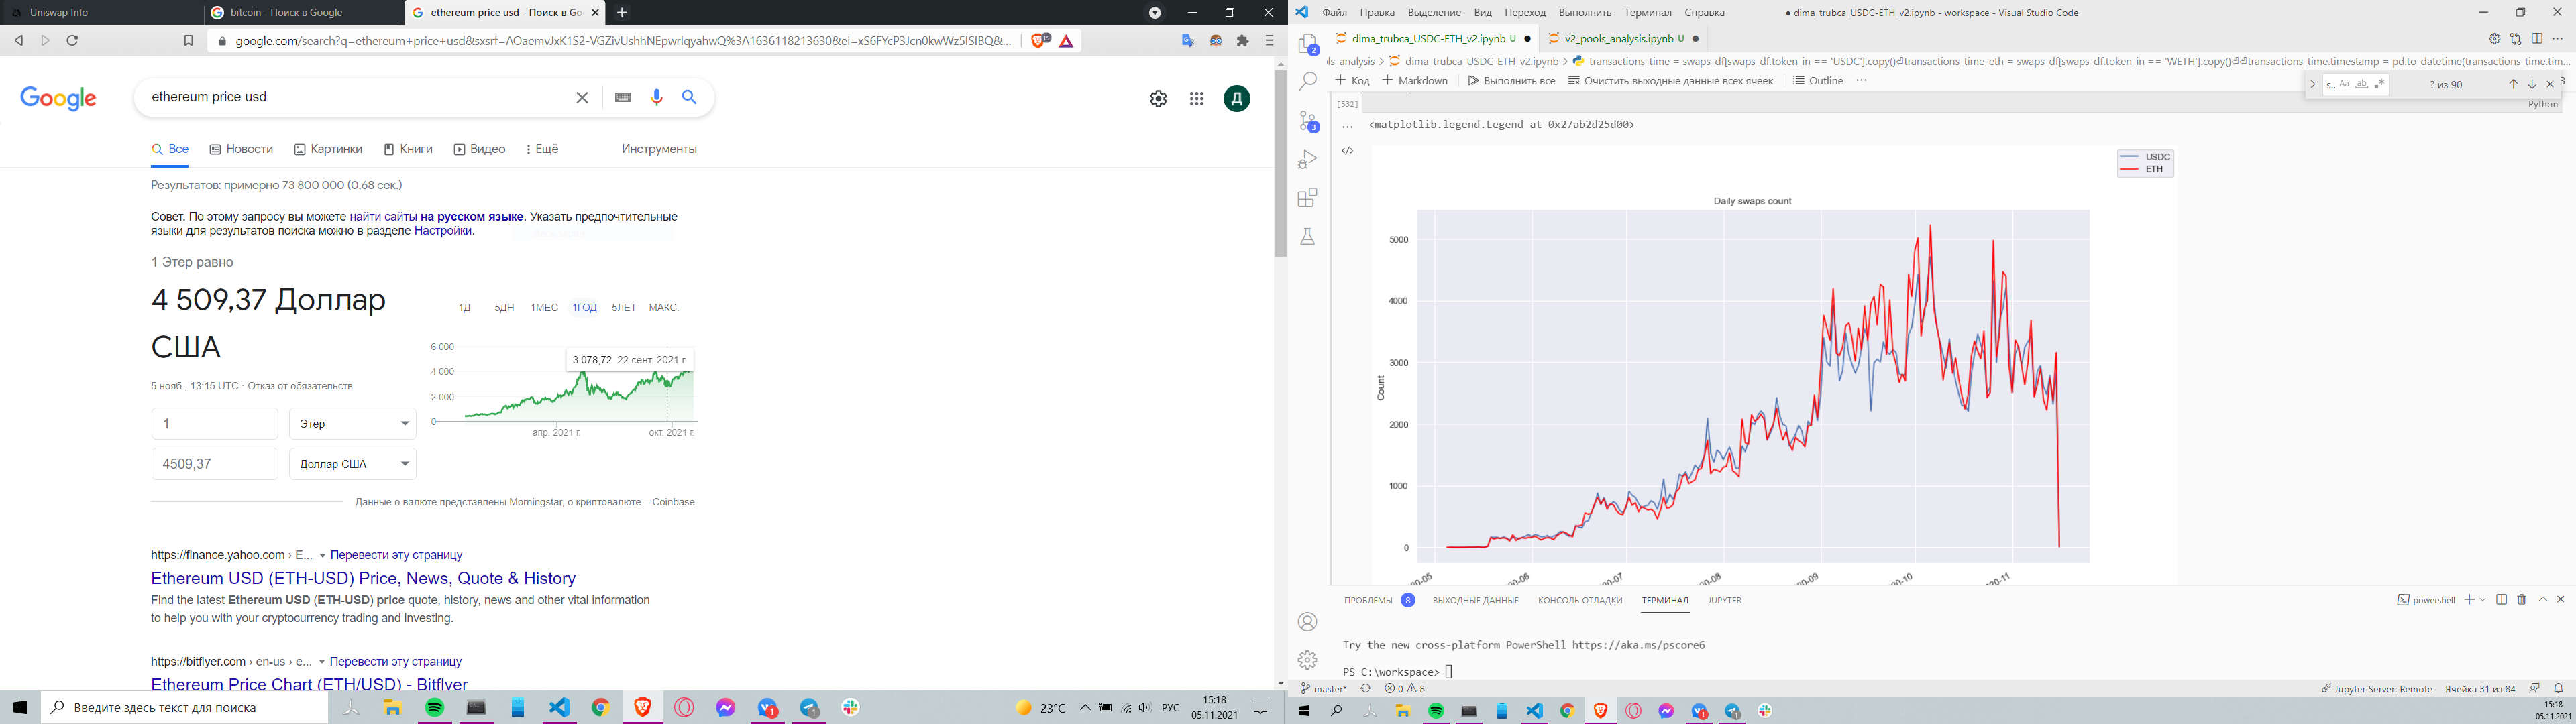

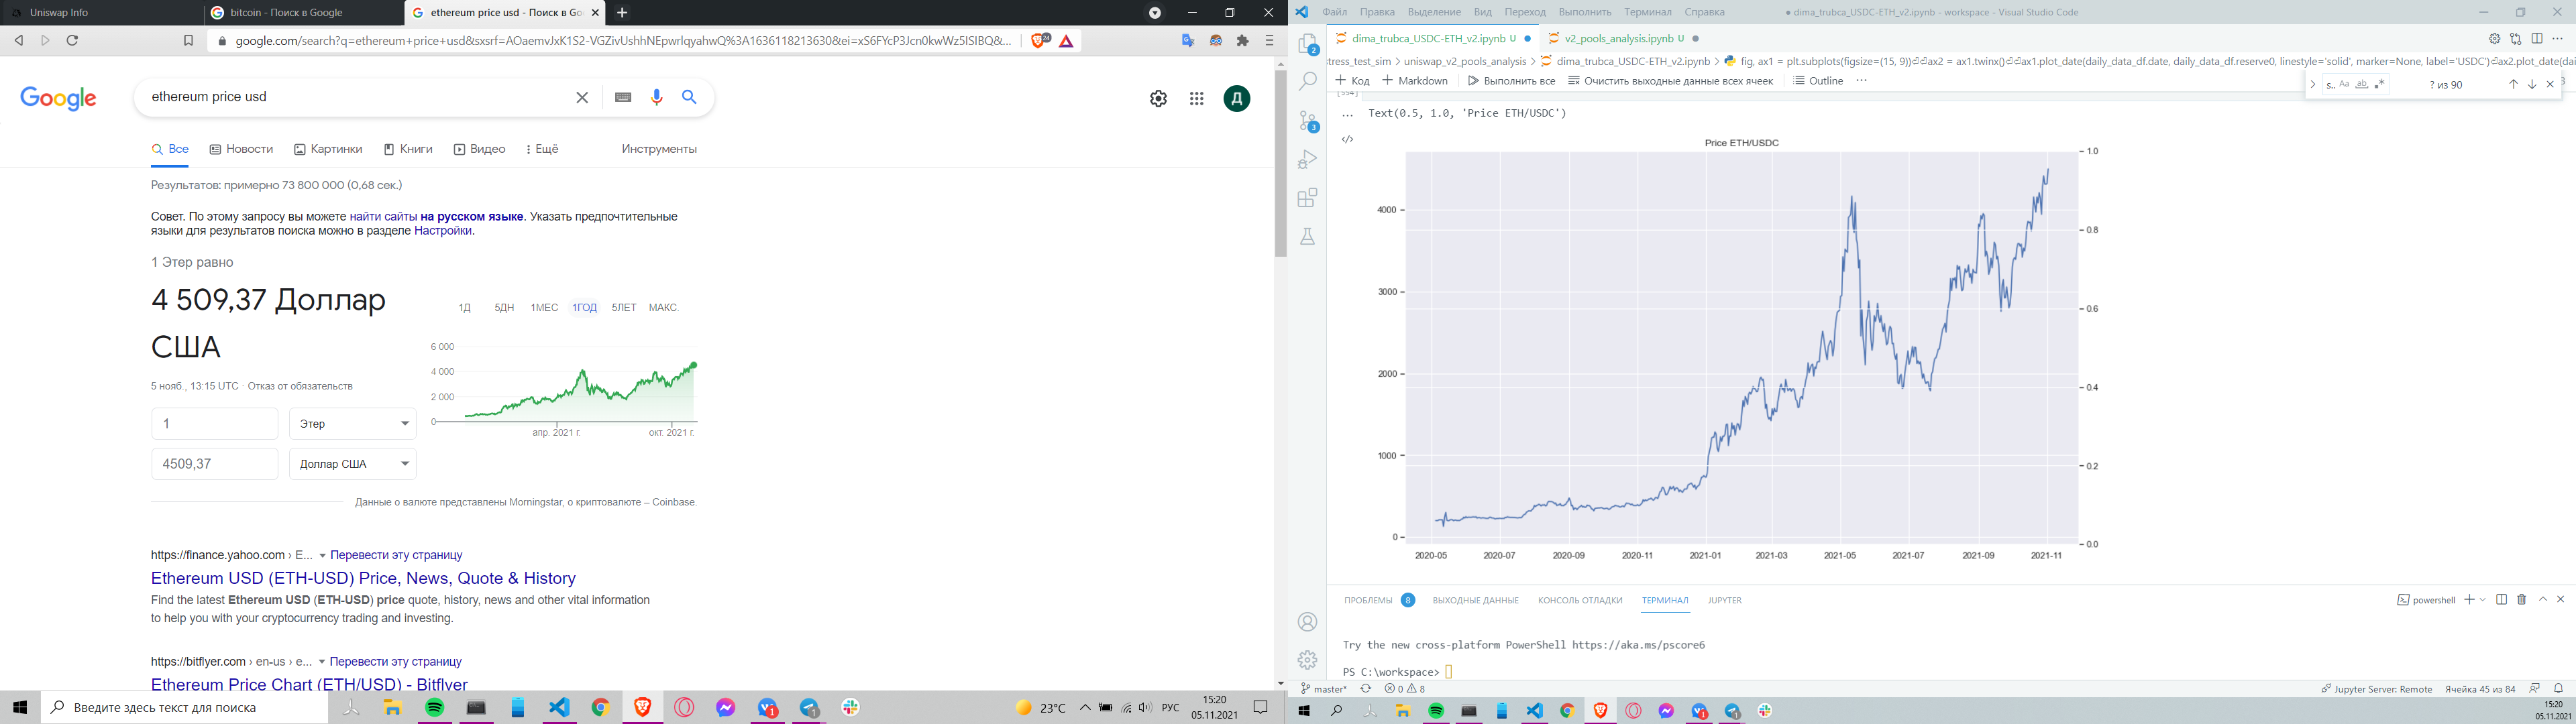

## ETH/USDT download and comparison with ETH/USDC

Considering ethereum price it will be interesting to compare story of this pool with story of previous one. For that it is required to download ETH/USDT information

In [ ]:
eth_usdt_history = get_pool_v2_history(contract_id='0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852', range_limit=4000)
eth_usdt_df = pool_history_to_df(eth_usdt_history)

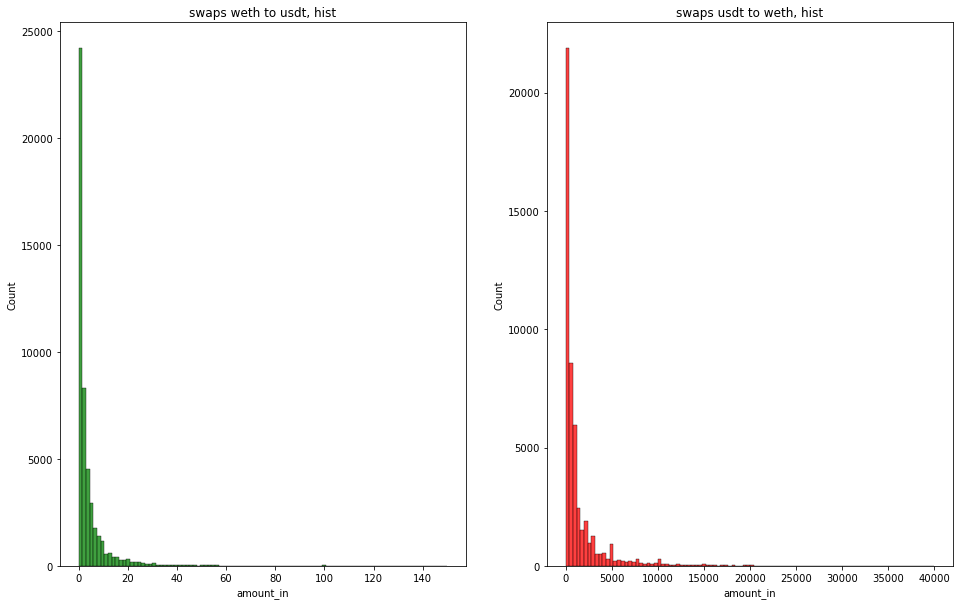

In [84]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
sns.histplot(eth_usdt_df[eth_usdt_df['token_in'] == 'WETH'].amount_in, bins=100, color='green', 
             binrange=[0, 150]).set_title('swaps weth to usdt, hist')

plt.subplot(1, 2, 2)
sns.histplot(eth_usdt_df[eth_usdt_df['token_in'] == 'USDT'].amount_in, bins=100, color='red', 
             binrange=[0, 40000]).set_title('swaps usdt to weth, hist')

plt.show()

Comparing the data of ETH/USDT pool and the data of ETH/USDC pool

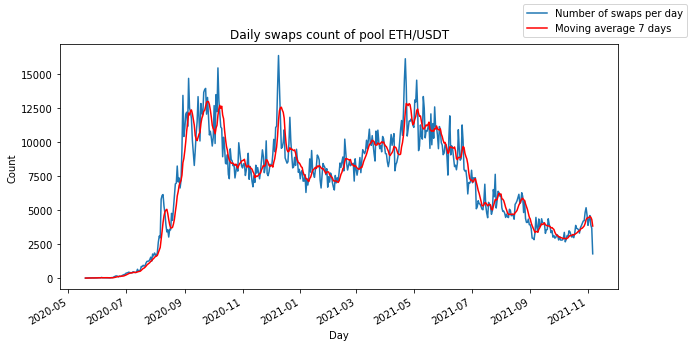

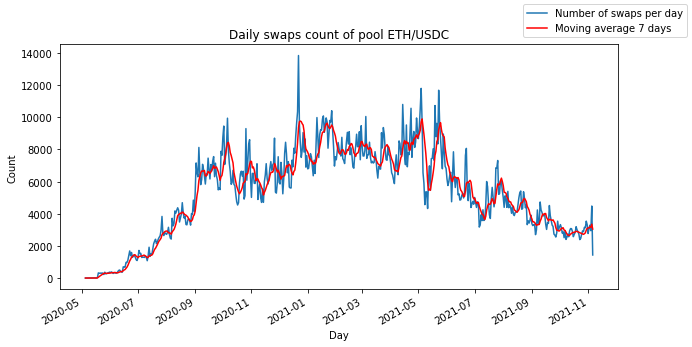

In [21]:
show_swaps_count_moving_averages(swaps_df=eth_usdt_df, pool_name="ETH/USDT")
show_swaps_count_moving_averages(swaps_df=eth_usdc_df, pool_name="ETH/USDC")

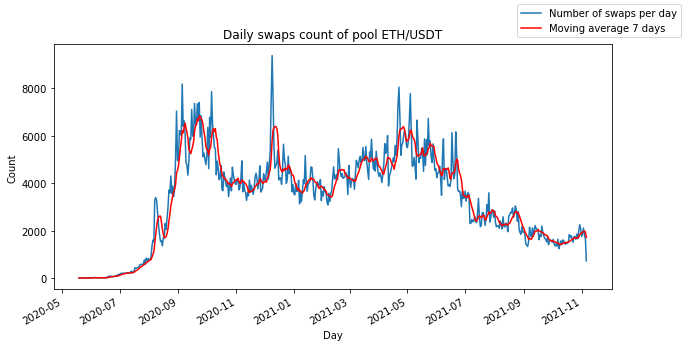

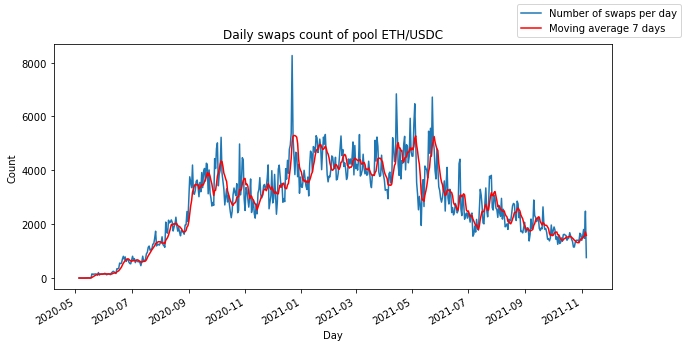

In [22]:
show_swaps_count_moving_averages(swaps_df=eth_usdt_df[eth_usdt_df.token_in == 'WETH'], pool_name="ETH/USDT")
show_swaps_count_moving_averages(swaps_df=eth_usdc_df[eth_usdc_df.token_in == 'WETH'], pool_name="ETH/USDC")

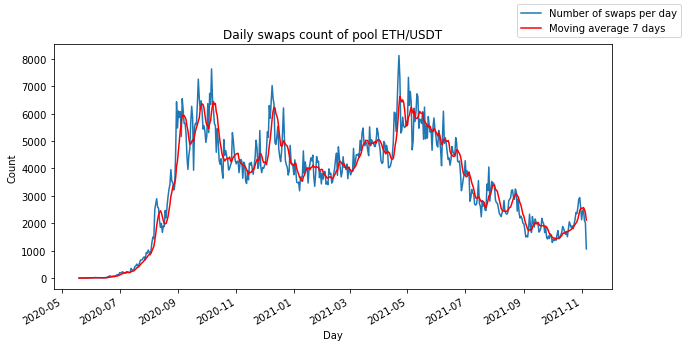

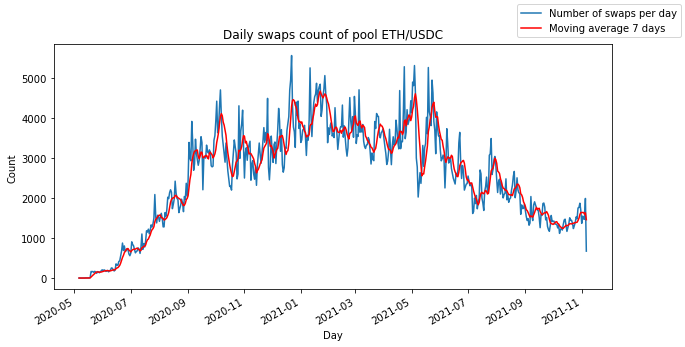

In [23]:
show_swaps_count_moving_averages(swaps_df=eth_usdt_df[eth_usdt_df.token_in == 'USDT'], pool_name="ETH/USDT")
show_swaps_count_moving_averages(swaps_df=eth_usdc_df[eth_usdc_df.token_in == 'USDC'], pool_name="ETH/USDC")

## Collecting reserves of the ETH/USDC and ETH/USDT pools data for analysis

In [49]:
eth_usdt_reserves = get_pool_v2_reserves_history(contract_id="0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852")
eth_usdc_reserves = get_pool_v2_reserves_history(contract_id="0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc")

  0%|                                                                                                                                                                                       | 0/2 [00:00<?, ?it/s]

list index out of range


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

list index out of range


In [58]:
eth_usdc_reserves_df = pool_reserves_to_df(eth_usdc_reserves)
eth_usdt_reserves_df = pool_reserves_to_df(eth_usdt_reserves)

### Comparing reserves data for ETH/USDC and ETH/USDT

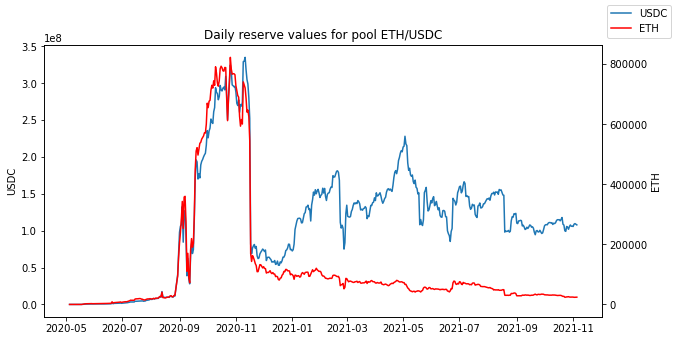

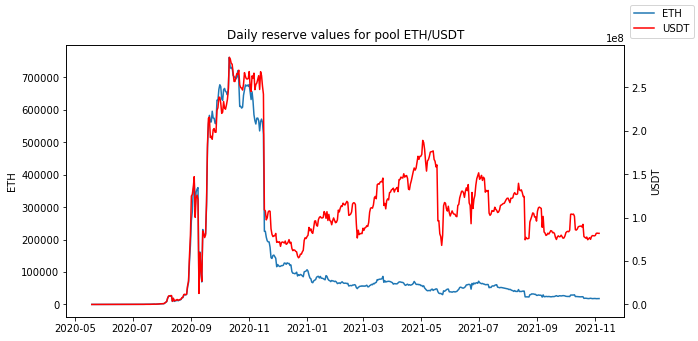

In [77]:
show_swaps_reserves_evolution_through_time(eth_usdc_reserves_df, first_token_symbol="USDC", 
                                           second_token_symbol="ETH", pool_name="ETH/USDC")
show_swaps_reserves_evolution_through_time(eth_usdt_reserves_df, first_token_symbol="ETH", 
                                           second_token_symbol="USDT", pool_name="ETH/USDT")

### Comparing pool prices evolution for ETH/USDC and ETH/USDT

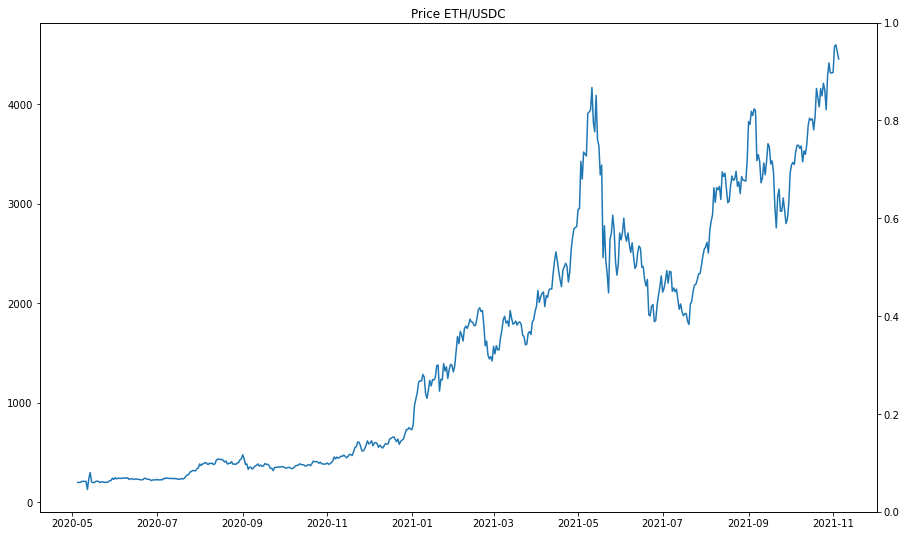

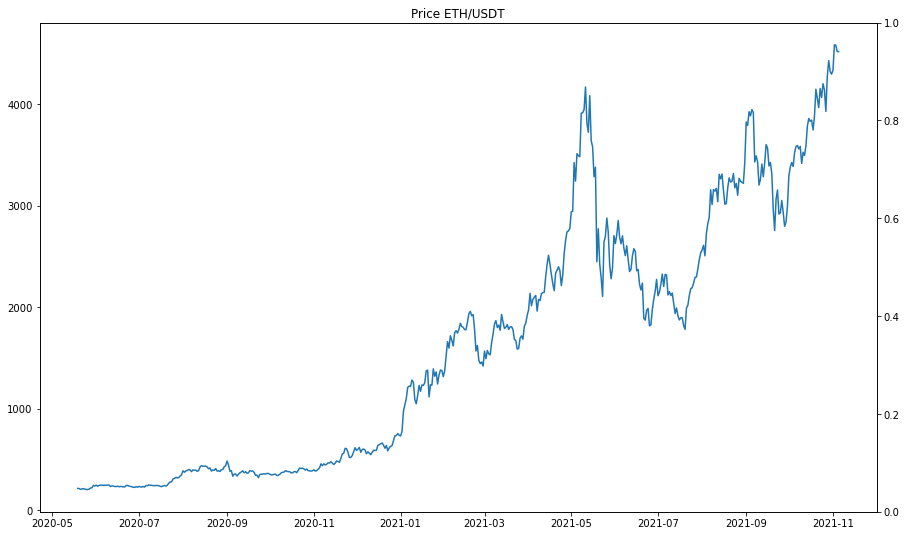

In [79]:
show_pool_price_evolution_from_reserves(eth_usdc_reserves_df, first_arg="reserve0", second_arg="reserve1", pool_name="ETH/USDC")
show_pool_price_evolution_from_reserves(eth_usdt_reserves_df, first_arg="reserve1", second_arg="reserve0", pool_name="ETH/USDT")

Results of the price evolution demonstrate that pool price is always stimulated to be equal to the real-market one. Distributions are very similar and their trends are similar.

**Suggestion to check**: charts show that there are drops in pool price. It will be interesting to check transactions what values are there. 

In [146]:
eth_usdt_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,date
0,WETH,USDT,0.000101,0.021717,0.021524,1589879176,2020-05-19 09:06:16
1,USDT,WETH,0.600000,0.002818,0.597769,1589922896,2020-05-19 21:14:56
2,USDT,WETH,0.025128,0.000118,0.025110,1589982256,2020-05-20 13:44:16
3,WETH,USDT,0.021047,4.441887,4.409261,1590014386,2020-05-20 22:39:46
4,WETH,USDT,0.010000,2.099140,2.087955,1590033851,2020-05-21 04:04:11
...,...,...,...,...,...,...,...
3658028,WETH,USDT,0.540191,2356.684786,2355.164378,1636202398,2021-11-06 12:39:58
3658029,WETH,USDT,0.676860,2952.735173,2950.893687,1636202415,2021-11-06 12:40:15
3658030,WETH,USDT,0.906883,3955.848778,3954.567355,1636202488,2021-11-06 12:41:28
3658031,WETH,USDT,0.156692,683.456525,683.347486,1636202574,2021-11-06 12:42:54


In [135]:
eth_usdc_df["date"] = pd.to_datetime(eth_usdc_df.timestamp, unit='s')

In [136]:
eth_usdt_df["date"] = pd.to_datetime(eth_usdt_df.timestamp, unit='s')

Information present on the next charts demonstrate that there is the same pool price behavior for both ETH/USDT and ETH/USDC pools with small deviations, and therefore both pools adapt their operations considering current token price (higher is the token price = lower values used for transactions, considering that now those tokens are more priceful)

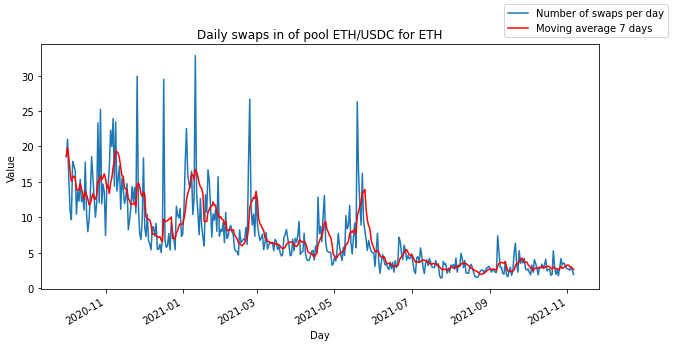

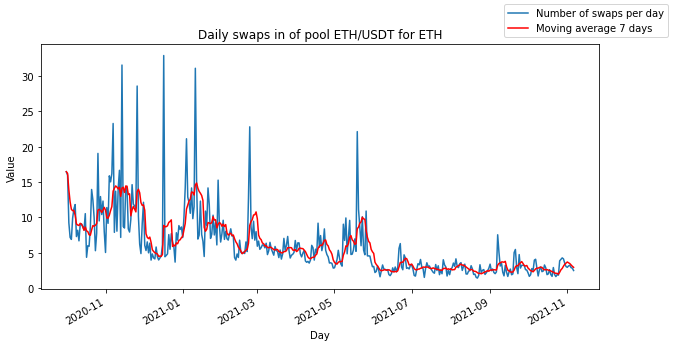

In [150]:
show_swaps_amount_in_moving_averages(swaps_df=eth_usdc_df[(eth_usdc_df.token_in == 'WETH') & 
            (eth_usdc_df.date > datetime.datetime(2020, 10, 1)) & 
            (eth_usdc_df.date < datetime.datetime(2021, 12, 1))
        ], pool_name="ETH/USDC for ETH")
show_swaps_amount_in_moving_averages(swaps_df=eth_usdt_df[(eth_usdt_df.token_in == 'WETH') & 
            (eth_usdt_df.date > datetime.datetime(2020, 10, 1)) & 
            (eth_usdt_df.date < datetime.datetime(2021, 12, 1))
        ], pool_name="ETH/USDT for ETH")

Transactions of stablecoin keep the same similar behavior independent from rise and falls of the altcoin token price, showing that pool is always adapting its distributions to altcoins, keeping stablecoins distributions simular.

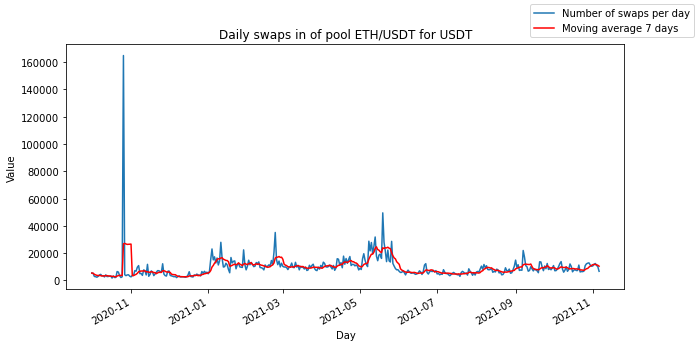

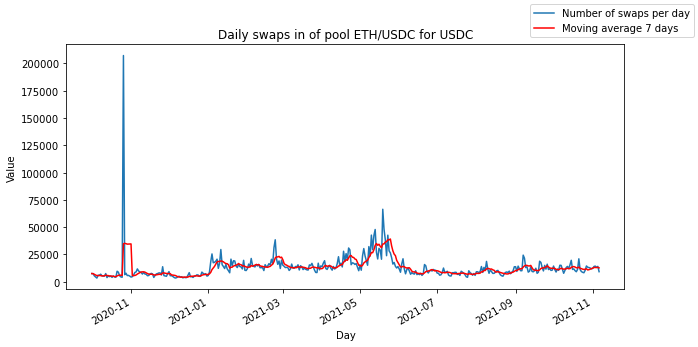

In [152]:
show_swaps_amount_in_moving_averages(swaps_df=eth_usdt_df[(eth_usdt_df.token_in == 'USDT') & 
            (eth_usdt_df.date > datetime.datetime(2020, 10, 1)) & 
            (eth_usdt_df.date < datetime.datetime(2021, 12, 1))
    ], pool_name="ETH/USDT for USDT")

show_swaps_amount_in_moving_averages(swaps_df=eth_usdc_df[(eth_usdc_df.token_in == 'USDC') & 
            (eth_usdc_df.date > datetime.datetime(2020, 10, 1)) & 
            (eth_usdc_df.date < datetime.datetime(2021, 12, 1))
    ], pool_name="ETH/USDC for USDC")

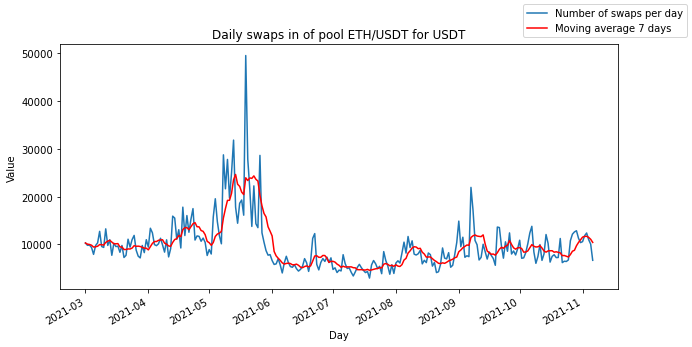

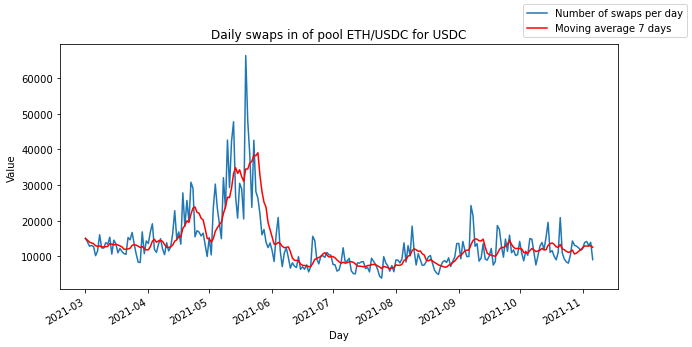

In [153]:
show_swaps_amount_in_moving_averages(swaps_df=eth_usdt_df[(eth_usdt_df.token_in == 'USDT') & 
            (eth_usdt_df.date > datetime.datetime(2021, 3, 1)) & 
            (eth_usdt_df.date < datetime.datetime(2021, 12, 1))
    ], pool_name="ETH/USDT for USDT")

show_swaps_amount_in_moving_averages(swaps_df=eth_usdc_df[(eth_usdc_df.token_in == 'USDC') & 
            (eth_usdc_df.date > datetime.datetime(2021, 3, 1)) & 
            (eth_usdc_df.date < datetime.datetime(2021, 12, 1))
    ], pool_name="ETH/USDC for USDC")

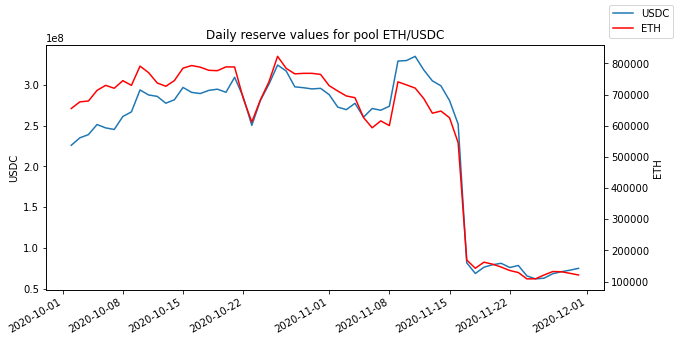

In [130]:
show_swaps_reserves_evolution_through_time(eth_usdc_reserves_df[
            (eth_usdc_reserves_df.date > datetime.datetime(2020, 10, 1)) & 
            (eth_usdc_reserves_df.date < datetime.datetime(2020, 12, 1))
    ], first_token_symbol="USDC", second_token_symbol="ETH", pool_name="ETH/USDC")

# Writing ETH/USDC pool information into pickle

In [144]:
eth_usdc_df.to_pickle('eth_usdc_df.pkl')
eth_usdc_reserves_df.to_pickle('eth_usdc_reserves_df.pkl')

eth_usdt_df.to_pickle('eth_usdt_df.pkl')
eth_usdt_reserves_df.to_pickle('eth_usdt_reserves_df.pkl')

In [2]:
eth_usdc_df = pd.read_pickle(os.getcwd() + "\\stress_test_sim\\uniswap_v2_pools_analysis\\pickles\\eth_usdc_df.pkl")
eth_usdt_df = pd.read_pickle(os.getcwd() + "\\stress_test_sim\\uniswap_v2_pools_analysis\\pickles\\eth_usdt_df.pkl")

## Picking best parameters for the Log-Normal distribution

In [3]:
eth_usdc_df['TokenSymbol'] = eth_usdc_df.token_in
eth_usdc_df['Value'] = eth_usdc_df.amount_in

In [4]:
eth_usdt_df['TokenSymbol'] = eth_usdt_df.token_in
eth_usdt_df['Value'] = eth_usdt_df.amount_in

print("ethereum max value in pool = " + str(eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'].Value.max()))
print("usdc max value in pool = " + str(eth_usdc_df[eth_usdc_df.TokenSymbol == 'USDC'].Value.max()))

ethereum max value in pool = 83047.79844840767
usdc max value in pool = 50165496.489468


In [10]:
dask_eth_usdc = dataframe.from_pandas(eth_usdc_df, npartitions=9)

### WETH/USDC parameter picking

In [5]:
def generator_week_df_and_plot(simulator: MonteCarloTransactionSimulator, time_window: int, x_size: int, y_size: int, x_bin_limit: int):
    current_iteration_timestamp = datetime.now()
    for index in range(time_window):
        simulator.generate_transactions(current_iteration_timestamp)
        current_iteration_timestamp += timedelta(milliseconds=simulator.frequency_generator.cycle_size)

    sim_df = simulator.get_dataframe()

    plt.figure(figsize=(x_size, y_size))
    print("simulator min token in = " + str(sim_df.TokenInAmount.min()))
    print("simulator max token in = " + str(sim_df.TokenInAmount.max()))
    sns.histplot(data=sim_df, x="TokenInAmount", bins=100, binrange=[0, x_bin_limit])
    plt.show()

    return sim_df

### Perform log-normal distribution parameter search for WETH side of WETH/USDC pool

In [12]:
# old version of searching, based on simple one-process work
print(eth_usdc_df.shape)
searcher = LognormalParameterSearcher(LognormalGenerator(mean=0, sigma=1500, limit=83000), eth_usdc_df, "WETH")
searcher.search_parameters(initial_sigma=5, sigma_step=0.1, final_sigma=7.1, title='WETH/USDC')
# import ray
# from timebudget import timebudget

# @ray.remote
# def local_search(starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str):
#     sys.path.insert(0, "C:/workspace/stress_test_sim//libs")
#     from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher

#     local_searcher = LognormalParameterSearcher(LognormalGenerator(mean=0, sigma=0, limit=83000), 
#                                                 df, token_symbol=token_symbol)
#     results = local_searcher.search_parameters(initial_sigma=starting_value, sigma_step=step_value, 
#                                      final_sigma=starting_value + 3 * step_value, title=pool_name)
    
    
# @timebudget
# def set_parallel_search(operation, starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str):
#     ray.get([operation.remote(starting_value + (i * 4 * step_value), step_value, df, token_symbol, pool_name) for i in range(4)])
    
# set_parallel_search(local_search, 20.6, 0.01, eth_usdc_df, 'WETH', 'WETH/USDC')

(2910939, 9)


KeyboardInterrupt: 

### Perform log normal distribution parameter search for USDC side of WETH/USDC pool

In [15]:
# old version of searching, based on simple one-process work
# print(eth_usdc_df.shape)
# searcher = LognormalParameterSearcher(LognormalGenerator(mean=0, sigma=1500), eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'], "WETH")
# searcher.search_parameters(initial_sigma=20, sigma_step=0.1, final_sigma=22, title='WETH/USDC')
import ray
from timebudget import timebudget

@ray.remote
def local_search(starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str, thread_iterations: int=3):
    sys.path.insert(0, "C:/workspace/stress_test_sim//libs")
    from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher

    print(">>>>>>>> starting value = " + str(starting_value))
    print(">>>>>>>> ending value = " + str(starting_value + thread_iterations * step_value))
    
    local_searcher = LognormalParameterSearcher(LognormalGenerator(mean=0, sigma=0, limit=50166000), 
                                                df, token_symbol=token_symbol)
    local_searcher.search_parameters(initial_sigma=starting_value, sigma_step=step_value, 
                                     final_sigma=starting_value + thread_iterations * step_value, 
                                     title=pool_name)
    
    
    
@timebudget
def set_parallel_search(operation, starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str, thread_iterations: int=3):
    ray.get([operation.remote(starting_value + (i * (thread_iterations + 1) * step_value), 
                              step_value, df, token_symbol, pool_name, thread_iterations) for i in range(4)])
    
set_parallel_search(local_search, 0, 10, eth_usdc_df.tail(5000), 'USDC', 'WETH/USDC')

 pid=11396) >>>>>>>> starting value = 40
 pid=11396) >>>>>>>> ending value = 70
 pid=11396) 50166000
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf inf inf ... inf inf inf]
 pid=11396) [inf 

(pid=1516) C:/workspace/stress_test_sim//libs\monte_carlo.py:145: RuntimeWarning: invalid value encountered in floor_divide
(pid=1516)   return value / ((value // self.limit) + 1)
(pid=8532) C:/workspace/stress_test_sim//libs\monte_carlo.py:145: RuntimeWarning: invalid value encountered in floor_divide
(pid=8532)   return value / ((value // self.limit) + 1)
(pid=8592) C:/workspace/stress_test_sim//libs\monte_carlo.py:145: RuntimeWarning: invalid value encountered in floor_divide
(pid=8592)   return value / ((value // self.limit) + 1)
(pid=11396) C:/workspace/stress_test_sim//libs\monte_carlo.py:145: RuntimeWarning: invalid value encountered in floor_divide
(pid=11396)   return value / ((value // self.limit) + 1)


 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=1516) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf inf inf ... inf inf inf]
 pid=8532) [inf 

In [28]:
print(np.mean(np.array(eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'].amount_in)))
print(np.std(np.array(eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'].amount_in), dtype=np.float64))
print(eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'].amount_in.max())

8.999839593285332
78.74851936208611
83047.79844840767


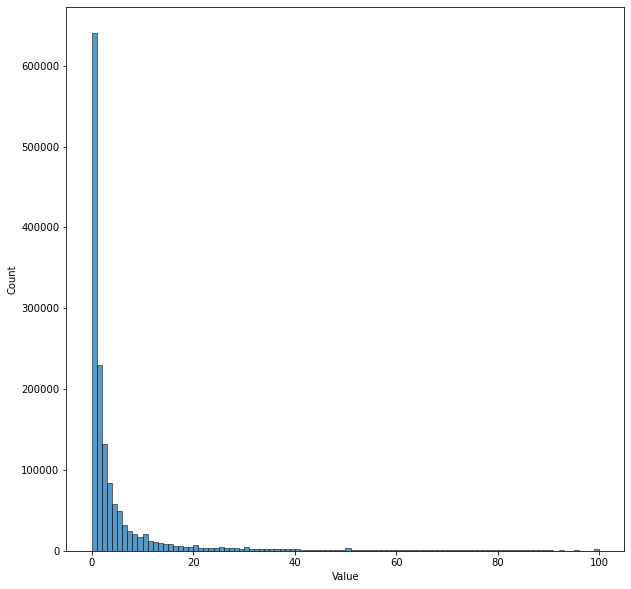

In [21]:
plt.figure(figsize=(10, 10))
sns.histplot(data=eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'], x='Value', bins=100, binrange=[0, 100])
plt.show()

### Log normal distribution simulation for WETH in WETH/USDC pool

Parameters for this pool were chosen using automatic parallel search

simulator min token in = 1.3026405923305805e-34
simulator max token in = 1.4126855439731233e+39


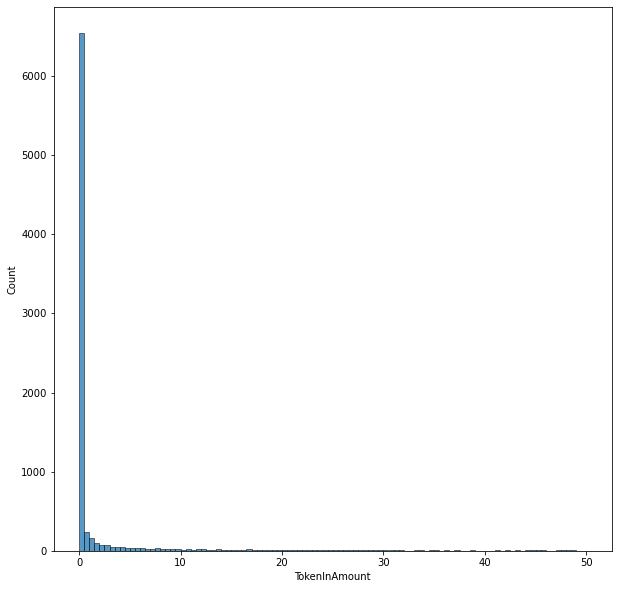

,datetime_timestamp,TokenIn,TokenInAmount,TokenOut,TokenOutAmount,Slope
0,2021-11-10 10:58:34.709176,ETH,3.623479e+08,DAI,NaN,0.05
1,2021-11-10 10:58:23.330176,ETH,1.836967e+02,DAI,NaN,0.05
2,2021-11-10 10:59:03.548176,ETH,3.960248e-06,DAI,NaN,0.05
3,2021-11-10 10:59:39.870176,ETH,5.227011e-01,DAI,NaN,0.05
4,2021-11-10 11:01:23.036176,ETH,1.078840e+06,DAI,NaN,0.05
...,...,...,...,...,...,...
20269,2021-11-17 10:55:45.422176,ETH,1.187394e-04,DAI,NaN,0.05
20270,2021-11-17 10:55:58.942176,ETH,6.850928e+07,DAI,NaN,0.05
20271,2021-11-17 10:56:56.216176,ETH,2.908879e-03,DAI,NaN,0.05
20272,2021-11-17 10:57:56.223176,ETH,5.072078e+09,DAI,NaN,0.05


In [20]:
lognormal_simulator = MonteCarloTransactionSimulator(
    PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
    LognormalGenerator(mean=8.999839593284912, sigma=20.610000000000003), 'ETH', 'DAI'
)

generator_week_df_and_plot(lognormal_simulator, 60*24*7, 10, 10, 50)

This simulation contains arguments chosen by author during manual parameter picking process

simulator min token in = 3.74769831413993e-142
simulator max token in = 2.617130662278306e+134


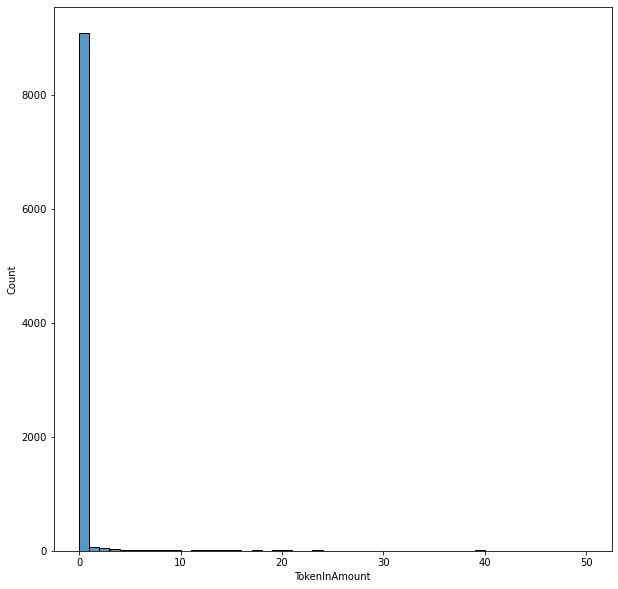

,datetime_timestamp,TokenIn,TokenInAmount,TokenOut,TokenOutAmount,Slope
0,2021-11-09 12:11:41.650496,ETH,1.287528e-12,DAI,NaN,0.05
1,2021-11-09 12:12:10.387496,ETH,6.176476e+23,DAI,NaN,0.05
2,2021-11-09 12:12:37.189496,ETH,1.363125e-26,DAI,NaN,0.05
3,2021-11-09 12:12:04.417496,ETH,2.239425e+50,DAI,NaN,0.05
4,2021-11-09 12:13:43.786496,ETH,2.228411e-09,DAI,NaN,0.05
...,...,...,...,...,...,...
20120,2021-11-16 12:09:34.375496,ETH,2.054792e-09,DAI,NaN,0.05
20121,2021-11-16 12:09:12.637496,ETH,1.190687e+25,DAI,NaN,0.05
20122,2021-11-16 12:10:03.386496,ETH,3.642025e+77,DAI,NaN,0.05
20123,2021-11-16 12:10:40.645496,ETH,3.731990e-29,DAI,NaN,0.05


In [17]:
lognormal_simulator = MonteCarloTransactionSimulator(
    PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
    LognormalGenerator(mean=8.999839593285332, sigma=78.74851936208611), 'ETH', 'DAI'
)

generator_week_df_and_plot(lognormal_simulator, 60*24*7, 10, 10, 50)

In [ ]:
lognormal_simulator = MonteCarloTransactionSimulator(
    PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
    LognormalGenerator(mean=8.999839593284912, sigma=20.610000000000003), 'ETH', 'DAI'
)

generator_week_df_and_plot(lognormal_simulator, 60*24*7, 10, 10, 50)

### Log normal distribution simulation for USDC in WETH/USDC pool

Parameters were picked using automatic parallel search

### Cauchy parameter search for WETH in WETH/USDC pool

(157.0453694387915, 1500)


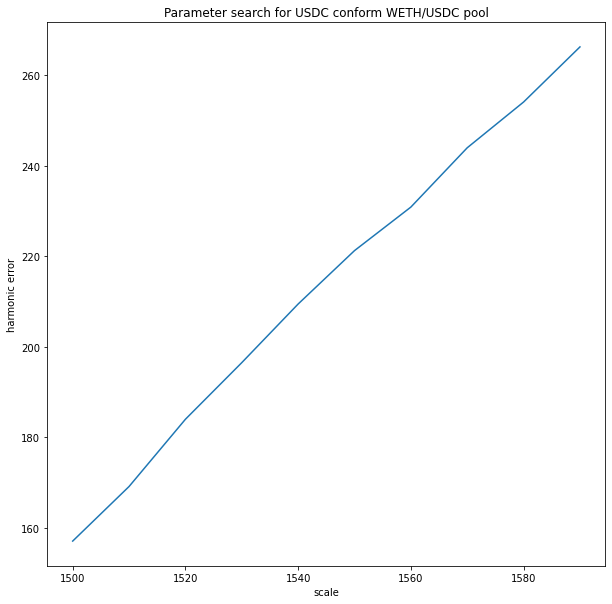

In [29]:
searcher = CauchyParameterSearcher(CauchyGenerator(loc=0, scale=15000, limit=50166000), eth_usdc_df, "USDC")

searcher.search_parameters(initial_scale=1500, step=10, final_scale=1600, acc=10, 
                            title='Parameter search for USDC conform WETH/USDC pool')

In [26]:
import ray
from timebudget import timebudget

@ray.remote
def local_search(starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str, thread_iterations: int=3):
    sys.path.insert(0, "C:/workspace/stress_test_sim//libs")
    from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher

    print(">>>>>>>> starting value = " + str(starting_value))
    print(">>>>>>>> ending value = " + str(starting_value + thread_iterations * step_value))
    
    local_searcher = CauchyParameterSearcher(CauchyGenerator(loc=0, scale=0, limit=50166000), 
                                                df, token_symbol=token_symbol)
    local_searcher.search_parameters(initial_scale=starting_value, step=step_value, 
                                     final_scale=starting_value + thread_iterations * step_value, 
                                     title=pool_name)
    
    
@timebudget
def set_parallel_search(operation, starting_value: float, step_value: float, df: pd.DataFrame, token_symbol: str, pool_name: str, thread_iterations: int=3):
    ray.get([operation.remote(starting_value + (i * (thread_iterations + 1) * step_value), 
                              step_value, df, token_symbol, pool_name, thread_iterations) for i in range(4)])
    
set_parallel_search(local_search, 3270, 1, eth_usdc_df.tail(5000), 'USDC', 'WETH/USDC')

 pid=25672) >>>>>>>> starting value = 3278
 pid=25672) >>>>>>>> ending value = 3281
 pid=9460) >>>>>>>> starting value = 3282
 pid=9460) >>>>>>>> ending value = 3285
 pid=27264) >>>>>>>> starting value = 3270
 pid=27264) >>>>>>>> ending value = 3273
 pid=19496) >>>>>>>> starting value = 3274
 pid=19496) >>>>>>>> ending value = 3277
 pid=9460) (7.621945034698093, 3282)
set_parallel_search took 1.342sec
 pid=25672) (16.174013176188666, 3278)
 pid=25672) Figure(1000x1000)
 pid=9460) Figure(1000x1000)
 pid=27264) (5.277835539861616, 3271)
 pid=27264) Figure(1000x1000)
 pid=19496) (7.050592331360527, 3274)
 pid=19496) Figure(1000x1000)


(0.0003705256527530716, 0.928)


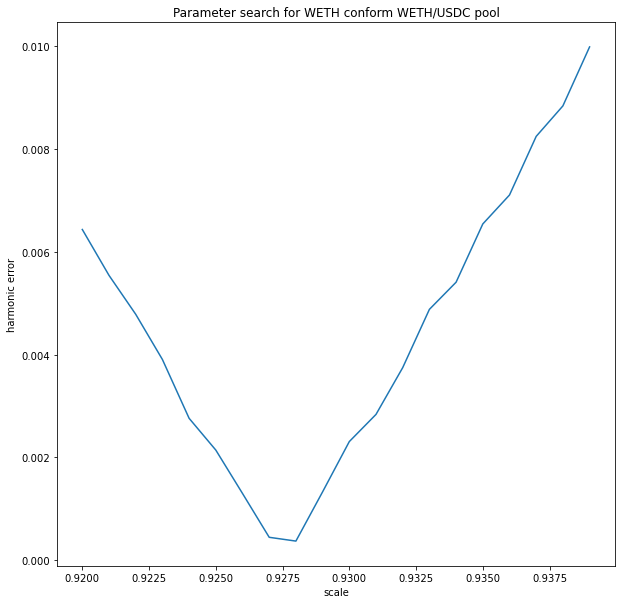

In [34]:
searcher = CauchyParameterSearcher(CauchyGenerator(loc=0, scale=15000, limit=550000), eth_usdc_df[eth_usdc_df.TokenSymbol == 'WETH'], "WETH")

searcher.search_parameters(initial_scale=0.92, step=0.001, final_scale=0.94, acc=100, 
                            title='Parameter search for WETH conform WETH/USDC pool')

simulator min token in = 1.2821233580725684e-05
simulator max token in = 99.98518361527216


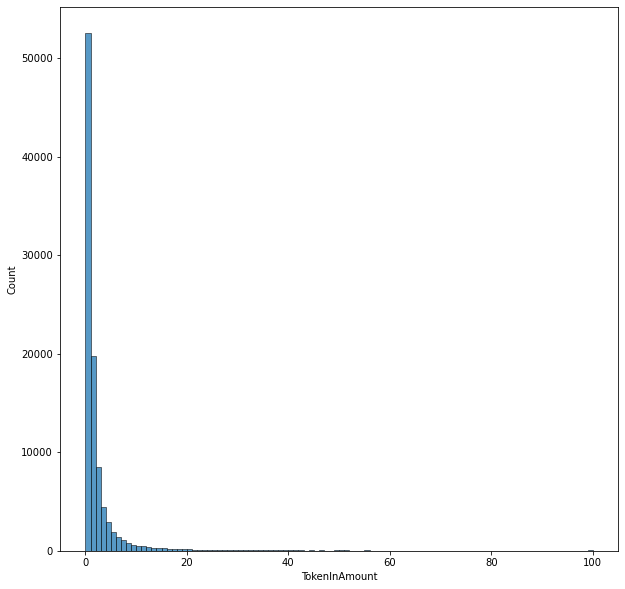

,datetime_timestamp,TokenIn,TokenInAmount,TokenOut,TokenOutAmount,Slope
0,2021-11-09 18:31:33.991639,ETH,1.463503,DAI,NaN,0.05
1,2021-11-09 18:31:30.300639,ETH,3.224123,DAI,NaN,0.05
2,2021-11-09 18:32:12.666639,ETH,0.994742,DAI,NaN,0.05
3,2021-11-09 18:31:34.412639,ETH,0.044608,DAI,NaN,0.05
4,2021-11-09 18:32:15.827639,ETH,1.450321,DAI,NaN,0.05
...,...,...,...,...,...,...
99964,2021-11-16 18:30:48.051639,ETH,0.063379,DAI,NaN,0.05
99965,2021-11-16 18:30:49.380639,ETH,1.148147,DAI,NaN,0.05
99966,2021-11-16 18:30:34.647639,ETH,10.965198,DAI,NaN,0.05
99967,2021-11-16 18:31:16.062639,ETH,0.358632,DAI,NaN,0.05


In [47]:
# version for the last 100 000 records
# cauchy_simulator = MonteCarloTransactionSimulator(
#     PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
#     CauchyGenerator(loc=0, scale=0.7400000000000003, limit=550000), 'ETH', 'DAI'
# )

# overall history version
cauchy_simulator = MonteCarloTransactionSimulator(
    PoissonGenerator(cycle_size=60000, mean_occurencies=10), 
    CauchyGenerator(loc=0, scale=0.928, limit=100), 'ETH', 'DAI'
)

generator_week_df_and_plot(cauchy_simulator, 60*24*7, 10, 10, 100)

# Getting information about Bitcoin-based pools

There are two pools that have good transaction history with Bitcoin: DAI and USDC ones. Considering that, here will be reviewed those pools

In [ ]:
wbtc_usdc_history = get_pool_v2_history(contract_id='0x004375dff511095cc5a197a54140a24efef3a416', range_limit=4000)
wbtc_usdc_df = pool_history_to_df(wbtc_usdc_history)

In [ ]:
wbtc_dai_history = get_pool_v2_history(contract_id='0x231b7589426ffe1b75405526fc32ac09d44364c4', range_limit=4000)
wbtc_dai_df = pool_history_to_df(wbtc_dai_history)

In [25]:
print(wbtc_usdc_df.shape)
wbtc_usdc_df.head(5)

(67555, 6)


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp
0,USDC,WBTC,1.534170e-01,0.000016,0.152773,2020-05-19 23:44:23
1,WBTC,USDC,2.501000e-04,2.367365,2.331250,2020-05-21 14:39:56
2,WBTC,USDC,1.047330e-03,9.603013,9.597534,2020-05-22 20:47:02
3,USDC,WBTC,8.923190e-01,0.000098,0.889846,2020-05-23 14:00:42
4,WBTC,USDC,1.100000e-07,0.001000,0.000989,2020-05-24 17:37:32


In [27]:
print(wbtc_dai_df.shape)
wbtc_dai_df.head(5)

(13701, 6)


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp
0,WBTC,DAI,0.000039,0.378642,0.378116,2020-05-20 11:55:36
1,WBTC,DAI,0.000017,0.162868,0.161100,2020-05-20 18:34:15
2,WBTC,DAI,0.000256,2.450812,2.382097,2020-05-22 00:32:08
3,WBTC,DAI,0.000022,0.208767,0.206079,2020-05-22 10:27:44
4,WBTC,DAI,0.000022,0.208199,0.205794,2020-05-22 10:30:29


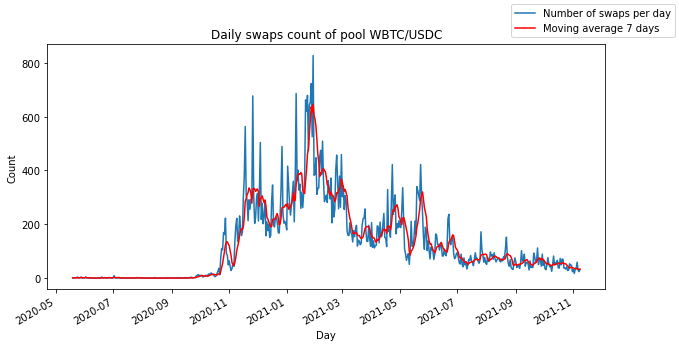

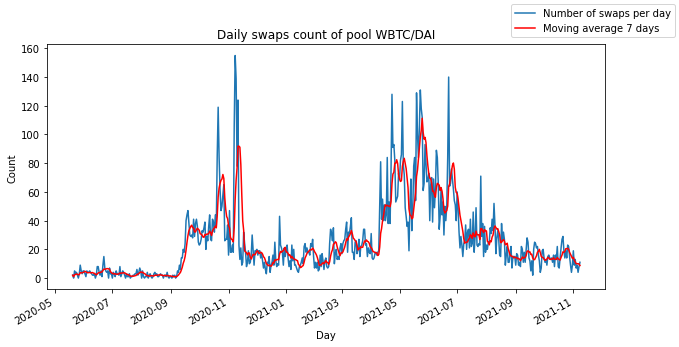

In [28]:
show_swaps_count_moving_averages(swaps_df=wbtc_usdc_df, pool_name="WBTC/USDC")
show_swaps_count_moving_averages(swaps_df=wbtc_dai_df, pool_name="WBTC/DAI")

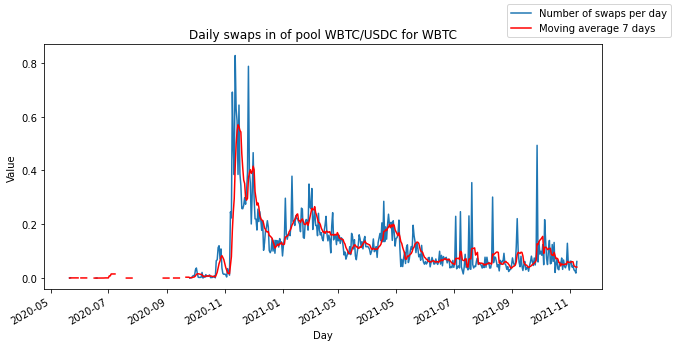

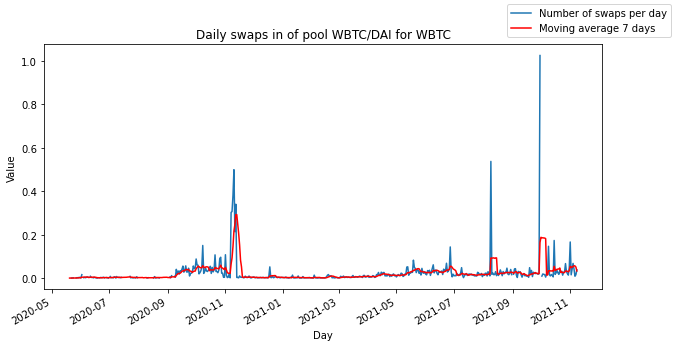

In [33]:
show_swaps_amount_in_moving_averages(swaps_df=wbtc_usdc_df[wbtc_usdc_df.token_in == 'WBTC'], pool_name="WBTC/USDC for WBTC")
show_swaps_amount_in_moving_averages(swaps_df=wbtc_dai_df[wbtc_dai_df.token_in == 'WBTC'], pool_name="WBTC/DAI for WBTC")

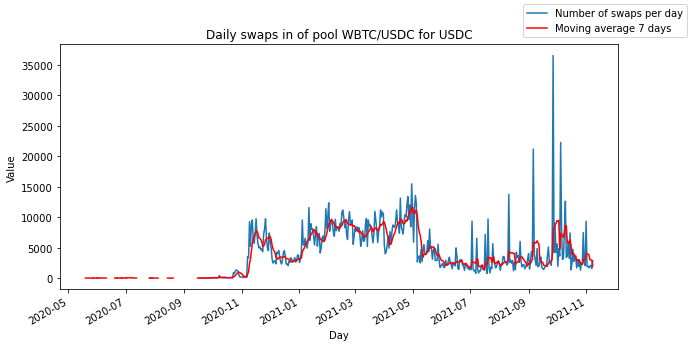

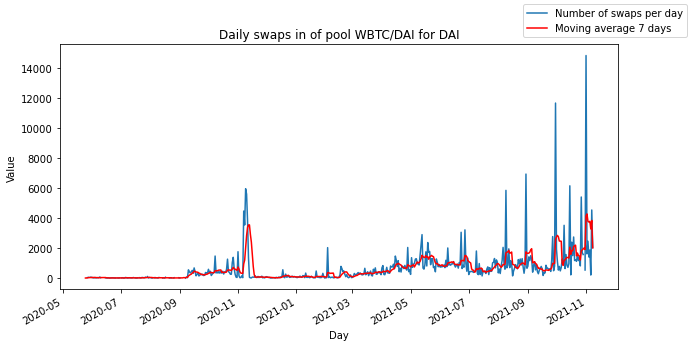

In [32]:
show_swaps_amount_in_moving_averages(swaps_df=wbtc_usdc_df[wbtc_usdc_df.token_in == 'USDC'], pool_name="WBTC/USDC for USDC")
show_swaps_amount_in_moving_averages(swaps_df=wbtc_dai_df[wbtc_dai_df.token_in == 'DAI'], pool_name="WBTC/DAI for DAI")

## Save WBTC/DAI and WBTC/USDC pools into pickle files

In [108]:
wbtc_usdc_df.to_pickle('wbtc_usdc_df.pkl')
wbtc_dai_df.to_pickle('wbtc_dai_df.pkl')

In [30]:
wbtc_usdc_df = pd.read_pickle(os.getcwd() + "/stress_test_sim/uniswap_v2_pools_analysis/wbtc_usdc_df.pkl")
wbtc_dai_df = pd.read_pickle(os.getcwd() + "/stress_test_sim/uniswap_v2_pools_analysis/wbtc_dai_df.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\workspace/stress_test_sim/uniswap_v2_pools_analysis/wbtc_usdc_df.pkl'